In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [2]:
LABELS = [0, 0, 1, 1]
CENTERS = [(-3, -3), (3, 3), (3, -3), (-3, 3)]

# 모델 정의

In [8]:
class MultilayerPerceptron(nn.Module):
    """
    """
    def __init__(self, input_size, hidden_size=2, output_size=3, 
                 num_hidden_layers=1, hidden_activation=nn.Sigmoid):
        """가중치 초기화

        매개변수:
            input_size (int): 입력 크기
            hidden_size (int): 은닉층 크기
            output_size (int): 출력 크기
            num_hidden_layers (int): 은닉층 개수
            hidden_activation (torch.nn.*): 활성화 함수
        """
        super(MultilayerPerceptron, self).__init__()
        self.module_list = nn.ModuleList()
        
        interim_input_size = input_size
        interim_output_size = hidden_size
        
        for _ in range(num_hidden_layers):
            self.module_list.append(nn.Linear(interim_input_size, interim_output_size))
            self.module_list.append(hidden_activation())
            interim_input_size = interim_output_size
            
        self.fc_final = nn.Linear(interim_input_size, output_size)
        
        self.last_forward_cache = []
       
    def forward(self, x, apply_softmax=False):
        """MLP의 정방향 계산
        
        매개변수:
            x_in (torch.Tensor): 입력 데이터 텐서
                x_in.shape는 (batch, input_dim)입니다.
            apply_softmax (bool): 소프트맥스 함수를 위한 플래그
                크로스 엔트로피 손실을 사용하려면 반드시 False로 지정해야 합니다
        반환값:
            결과 텐서. tensor.shape는 (batch, output_dim)입니다.
        """
        self.last_forward_cache = []
        self.last_forward_cache.append(x.to("cpu").numpy())

        for module in self.module_list:
            x = module(x)
            self.last_forward_cache.append(x.to("cpu").data.numpy())
            
        output = self.fc_final(x)
        self.last_forward_cache.append(output.to("cpu").data.numpy())

        if apply_softmax:
            output = F.softmax(output, dim=1)
            
        return output

In [9]:
def get_toy_data(batch_size):
    assert len(CENTERS) == len(LABELS), 'centers should have equal number labels'
    
    x_data = []
    y_targets = np.zeros(batch_size)
    n_centers = len(CENTERS)
    
    for batch_i in range(batch_size):
        center_idx = np.random.randint(0, n_centers)
        x_data.append(np.random.normal(loc=CENTERS[center_idx]))
        y_targets[batch_i] = LABELS[center_idx]
        
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.int64)

In [10]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    _, y_pred = perceptron(x_data, apply_softmax=True).max(dim=1)
    y_pred = y_pred.data.numpy()

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy()


    n_classes = len(set(LABELS))

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['orange', 'green']
    markers = ['o', '*']
    edge_color = {'o':'orange', '*':'green'}
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append('white')
        else:
            all_colors[y_true_i].append(colors[y_true_i])

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor=edge_color[marker], marker=marker, facecolor=color_list, s=100)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))
            
    # 초평면
    xx = np.linspace(xlim[0], xlim[1], 30) # np.linspace(start,end,num), start ~ end 까지 num개 요소의 1차원 배열생성
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx) 
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    for i in range(n_classes):
        Z = perceptron(torch.tensor(xy, dtype=torch.float32), 
                       apply_softmax=True)
        Z  = Z[:, i].data.numpy().reshape(XX.shape)
        ax.contour(XX, YY, Z, colors=colors[i], levels=levels, linestyles=linestyles)
    
    # 부가 출력
    plt.suptitle(title)
  
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

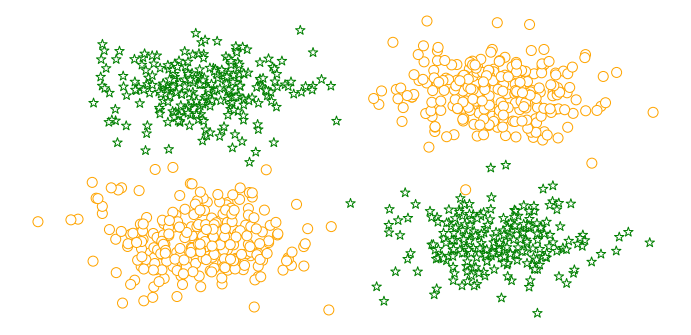

In [11]:
seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy().astype(np.int64)

n_classes = len(set(LABELS))

all_x = [[] for _ in range(n_classes)]
all_colors = [[] for _ in range(n_classes)]

colors = ['orange', 'green']
markers = ['o', '*']

for x_i, y_true_i in zip(x_data, y_truth):
    all_x[y_true_i].append(x_i)
    all_colors[y_true_i].append(colors[y_true_i])

all_x = [np.stack(x_list) for x_list in all_x]


_, ax = plt.subplots(1, 1, figsize=(10,5))

for x_list, color, marker in zip(all_x, all_colors, markers):
    ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor=color, marker=marker, facecolor="white", s=100)

plt.tight_layout()
plt.axis('off')

plt.title("");

plt.savefig("initial_data.png", dpi=300)


# 퍼셉트론 훈련
하나의 퍼셉트론은 하나의 다층 퍼셉트론입니다. 이를 잘 드러내기 위해 변수 이름을 mlp1이라고 쓰겠습니다. 위에서 정의한 클래스에 num_hidden_layers=0를 지정해 퍼셉트론을 만들겠습니다.

MultilayerPerceptron(
  (module_list): ModuleList()
  (fc_final): Linear(in_features=2, out_features=2, bias=True)
)


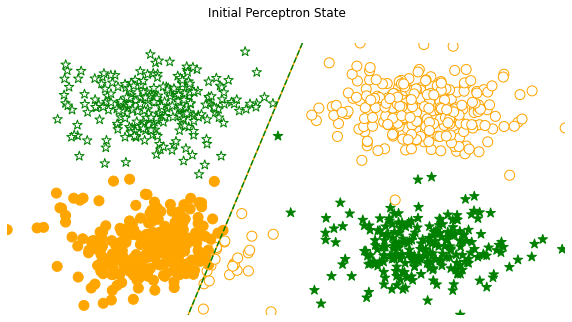

In [15]:
input_size = 2
output_size = len(set(LABELS))
num_hidden_layers = 0
hidden_size = 2 # 실제로 사용하지 않지만 지정합니다

seed = 24

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

mlp1 = MultilayerPerceptron(input_size=input_size, 
                            hidden_size=hidden_size, 
                            num_hidden_layers=num_hidden_layers, 
                            output_size=output_size)
print(mlp1)
batch_size = 1000

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(mlp1, x_data_static, y_truth_static, 
                  ax=ax, title='Initial Perceptron State', levels=[0.5])

plt.axis('off')
plt.savefig('perceptron_initial.png', dpi=300)

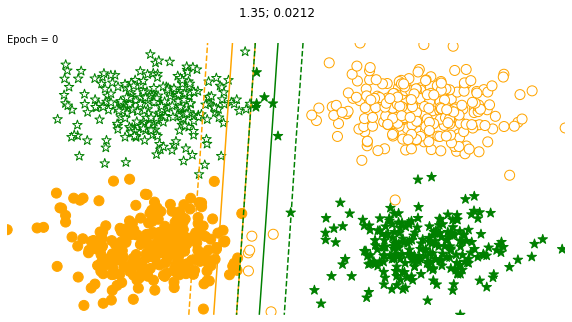

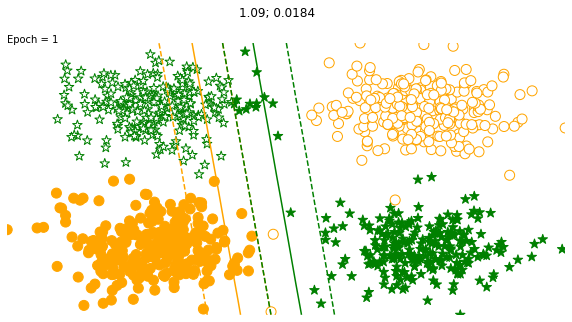

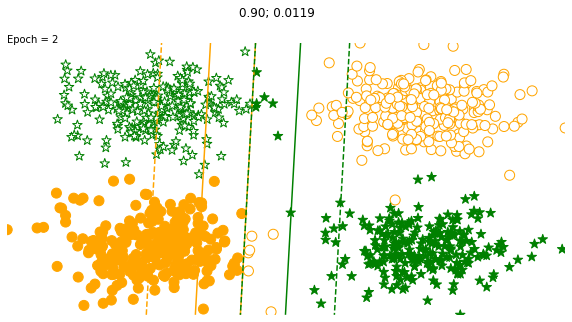

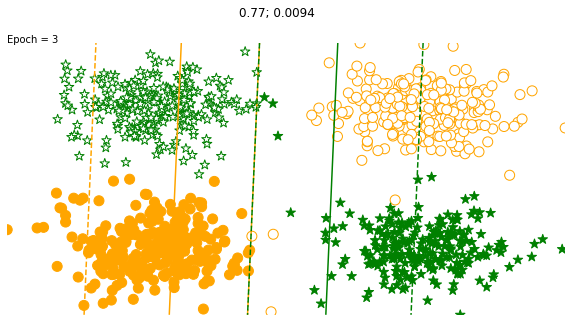

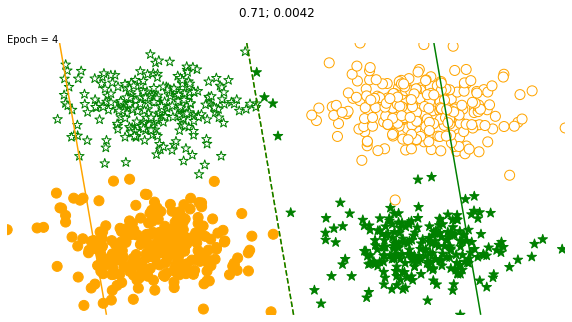

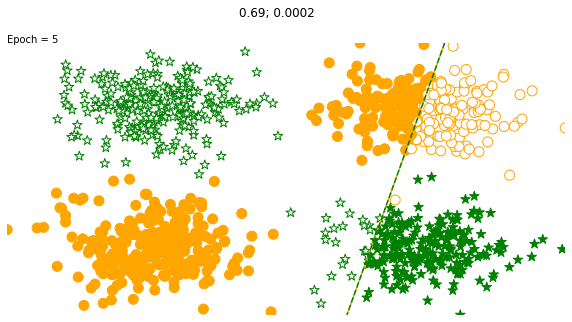

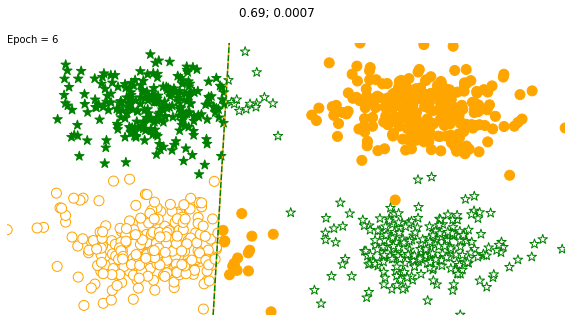

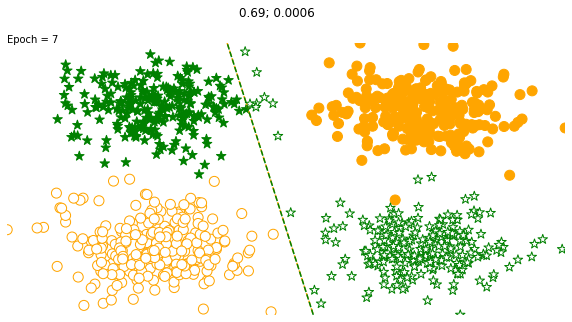

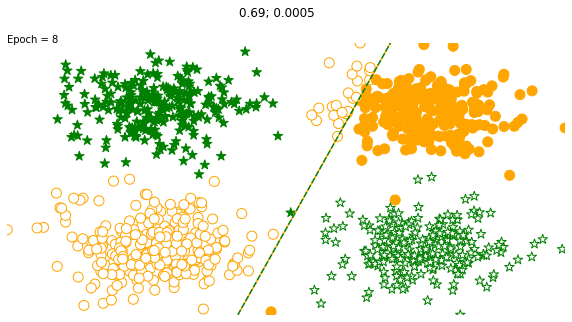

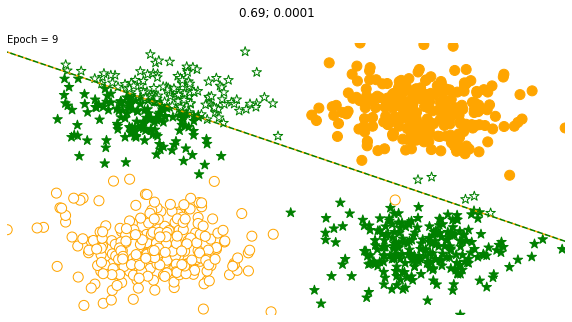

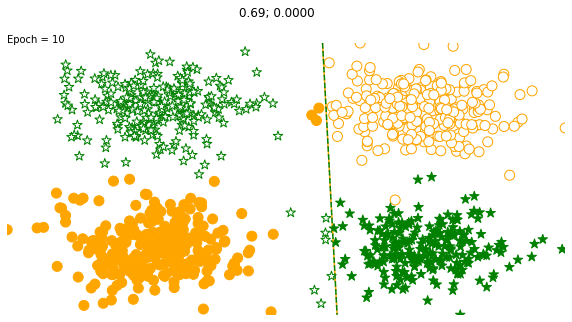

In [13]:
losses = []
batch_size = 10000
n_batches = 10
max_epochs = 10

loss_change = 1.0
last_loss = 10.0
change_threshold = 1e-3
epoch = 0
all_imagefiles = []

lr = 0.01
optimizer = optim.Adam(params=mlp1.parameters(), lr=lr)
cross_ent_loss = nn.CrossEntropyLoss()

def early_termination(loss_change, change_threshold, epoch, max_epochs):
    terminate_for_loss_change = loss_change < change_threshold
    terminate_for_epochs = epoch > max_epochs
    
    return terminate_for_epochs

while not early_termination(loss_change, change_threshold, epoch, max_epochs):
    for _ in range(n_batches):
        # 단계 0: 데이터 추출
        x_data, y_target = get_toy_data(batch_size)
 
        # 단계 1: 그레이디언트 초기화
        mlp1.zero_grad()
        
        # 단계 2: 정방향 계산 수행
        y_pred = mlp1(x_data).squeeze()
        
        # 단계 3: 손실 계산
        loss = cross_ent_loss(y_pred, y_target.long())

        # 단계 4: 역방향 계산
        loss.backward()
        
        # 단계 5: 옵티마이저 단계 수행
        optimizer.step()
        
        # 부가 정보
        loss_value = loss.item()
        losses.append(loss_value)
        loss_change = abs(last_loss - loss_value)
        last_loss = loss_value
                
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(mlp1, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value:0.2f}; {loss_change:0.4f}")
    plt.axis('off')
    epoch += 1
    all_imagefiles.append(f'perceptron_epoch{epoch}_toylearning.png')
    plt.savefig(all_imagefiles[-1], dpi=300)
